In [1]:
import json
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')
import glob
import matplotlib.pyplot as plt

## Steps to skip as we have a CSV

In [5]:

# load main results
results_df = pd.read_csv("../ALL_DSI-lziv_output.csv", header=0, sep=",")
# load results from human data previous study;
dsi_paper = pd.read_csv('../DSI_output.csv')
lziv_dsi_paper = pd.read_csv('../dsi-paper_DSI-lziv_output.csv')
# change condition name
lziv_dsi_paper['condition'].replace('synopsis', 'flash-fiction', inplace=True)
# load in the human ratings
lziv_dsi_paper[['StoryRater1', 'StoryRater2', 'StoryRater3', 'StoryRater4', 'StoryRater5', 'StoryRaterMean']] = dsi_paper[['StoryRater1', 'StoryRater2', 'StoryRater3', 'StoryRater4', 'StoryRater5', 'StoryRaterMean']]

# load in gpt4 ratings on the human stories
with open("/home/franc/git/DAT_GPT/samples/sample_gpt4_rater3_temp1.0_story_rater10.json", "r") as f:
    ratings = json.load(f)
ratings = {k: int(v) for k, v in ratings.items()}
# split the gpt4 rating1 column into multiple columns of 179 rows
# not elegant but does the trick
gpt4_ratings = list(ratings.values())
rating1 = gpt4_ratings[0:179]
rating2 = gpt4_ratings[179:358]
rating3 = gpt4_ratings[358:537]
# arrange data
gpt4_ratings = pd.DataFrame()
gpt4_ratings['gpt4_rating1'] = rating1
gpt4_ratings['gpt4_rating2'] = rating2
gpt4_ratings['gpt4_rating3'] = rating3
# compute mean
gpt4_ratings['gpt4_avg'] = gpt4_ratings[['gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3', ]].mean(axis=1)
# add to human stories dataframe
lziv_dsi_paper[['gpt4_rating1','gpt4_rating2','gpt4_rating3','gpt4_avg']] = gpt4_ratings[['gpt4_rating1','gpt4_rating2','gpt4_rating3', 'gpt4_avg']]
# concatenate the our dataframe with the human data
results_df = pd.concat([results_df ,lziv_dsi_paper], ignore_index=True)

# typo
results_df['temp'].replace('n.a.', 'Mid', inplace=True)

In [19]:
# load in the gpt4 ratings from the machine stories
dict_ratings = {}
for fn in glob.glob("../machine_data_stories/ratings/*.json"):
    with open(fn, "r") as f:
        ratings_ = json.load(f)
    if "rater_GPT4-Mid-flash-fiction" in fn:
        dict_ratings.update({"gpt4":ratings_})
    elif "rater_GPT3-Mid-flash-fiction" in fn:
        dict_ratings.update({"gpt3":ratings_})
    elif "rater_Vicuna-Mid-flash-fiction" in fn:
        dict_ratings.update({"vicuna":ratings_})
    else:
        continue
    

In [20]:
# arrange the ratings in a the main dataframe ; ratings only considered the flash fiction condition
for model in results_df['model'].unique():
    if model == 'human':
        continue
    for idx in dict_ratings[model.lower()].keys():
        # Select the rows that match the condition
        mask = (results_df['model'] == model) & (results_df['condition'] == 'flash-fiction') & (results_df['temp'] == 'Mid')
        rows = results_df.loc[mask].copy()
        i = int(idx)+1
        # Set the value for all rows
        rows[f'gpt4_rating{i}'] = [float(val) for val in dict_ratings[model.lower()][idx].values()]

        # Update the original DataFrame with the modified rows
        results_df.loc[mask, rows.columns] = rows

In [21]:
results_df['gpt4_avg'] = results_df[['gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3', 'gpt4_rating4', 'gpt4_rating5']].mean(axis=1)

# Run from here

In [2]:
#results_df.to_csv('../all_stories_dsi_lziv_ratings_num-words.csv', index=False)
results_df = pd.read_csv('../all_stories_dsi_lziv_ratings_num-words.csv')

In [5]:
results_df.columns

Index(['DSI', 'story', 'model', 'condition', 'temp', 'num_words', 'lziv',
       'StoryRater1', 'StoryRater2', 'StoryRater3', 'StoryRater4',
       'StoryRater5', 'StoryRaterMean', 'gpt4_rating1', 'gpt4_rating2',
       'gpt4_rating3', 'gpt4_avg', 'gpt4_rating4', 'gpt4_rating5'],
      dtype='object')

In [6]:
export = results_df.drop(columns='story')

In [8]:
export = export.loc[export['condition']=="flash-fiction"]

In [10]:
export.to_csv('inter-rater-relliability.csv')

# Human stories only
## Correlation between gpt4 and human ratings

Text(0.5, 0.95, 'flash-fiction | Mid - r=0.73, p=0.0000')

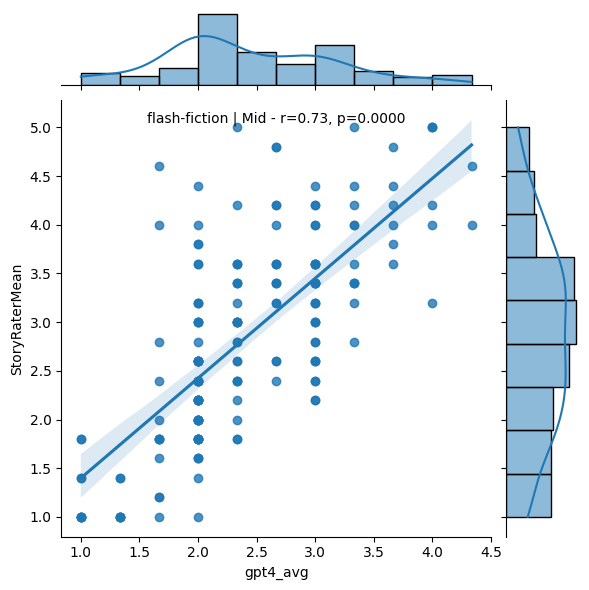

In [11]:
condition = 'flash-fiction'

df = results_df.loc[(results_df['condition']==condition) &
                    (results_df['temp']=='Mid') &
                    (results_df['model']=='human')]
g = sns.jointplot(x='gpt4_avg', y='StoryRaterMean', data=df ,kind='reg')
# add r value and p-value in upper right corner
r, p = stats.pearsonr(df['gpt4_avg'], df['StoryRaterMean'])
g.ax_joint.annotate(f"{condition} | Mid - r={r:.2f}, p={p:.4f}", xy=(0.5, 0.95), xycoords='axes fraction', ha='center')

Text(0.5, 0.95, 'flash-fiction | Mid - r=0.75, p=0.0000')

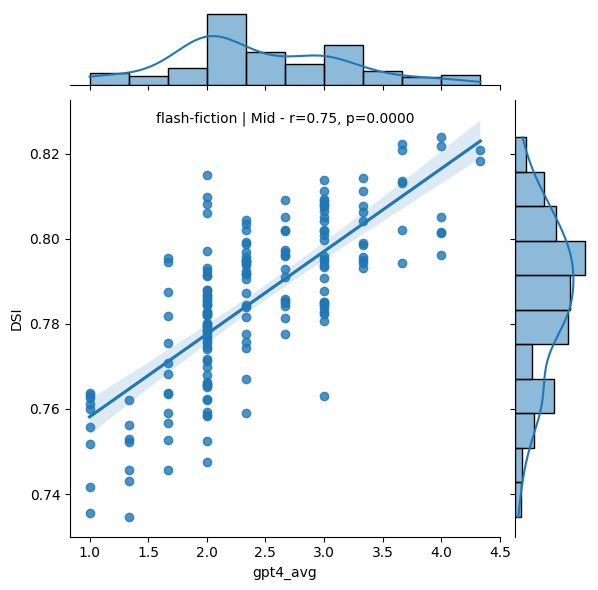

In [12]:
condition = 'flash-fiction'

df = results_df.loc[(results_df['condition']==condition) &
                    (results_df['temp']=='Mid') &
                    (results_df['model']=='human')].dropna(axis=1)
g = sns.jointplot(x='gpt4_avg', y='DSI', data=df ,kind='reg')
# add r value and p-value in upper right corner
r, p = stats.pearsonr(df['gpt4_avg'], df['DSI'])
g.ax_joint.annotate(f"{condition} | Mid - r={r:.2f}, p={p:.4f}", xy=(0.5, 0.95), xycoords='axes fraction', ha='center')

# LLM stories
## DSI and GPT-4 average rating

Text(0.5, 0.95, 'flash-fiction | Mid - r=0.57, p=0.0000')

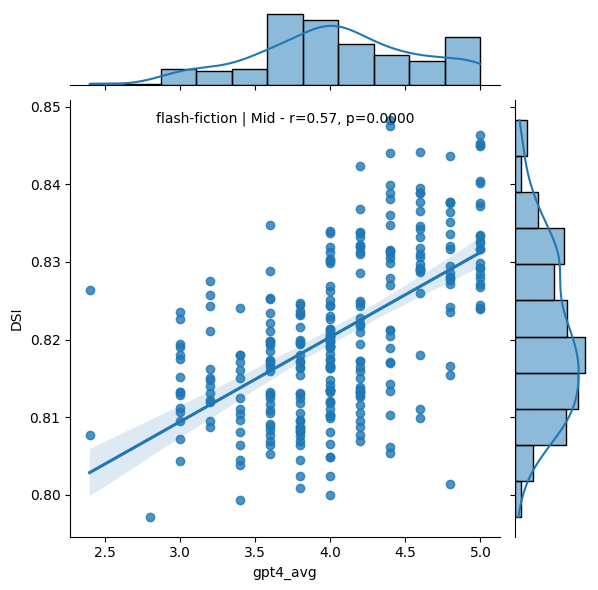

In [13]:
condition = 'flash-fiction'

df = results_df.loc[(results_df['condition']==condition) &
                    (results_df['temp']=='Mid') &
                    (results_df['model']!='human')].dropna(axis=1)
g = sns.jointplot(x='gpt4_avg', y='DSI', data=df ,kind='reg')
# add r value and p-value in upper right corner
r, p = stats.pearsonr(df['gpt4_avg'], df['DSI'])
g.ax_joint.annotate(f"{condition} | Mid - r={r:.2f}, p={p:.4f}", xy=(0.5, 0.95), xycoords='axes fraction', ha='center')

## Look within model at Mid temp.

GPT4 | flash-fiction | Mid - r=0.14, p=0.16
Vicuna | flash-fiction | Mid - r=0.11, p=0.29
GPT3 | flash-fiction | Mid - r=0.02, p=0.81
human | flash-fiction | Mid - r=0.75, p=0.00


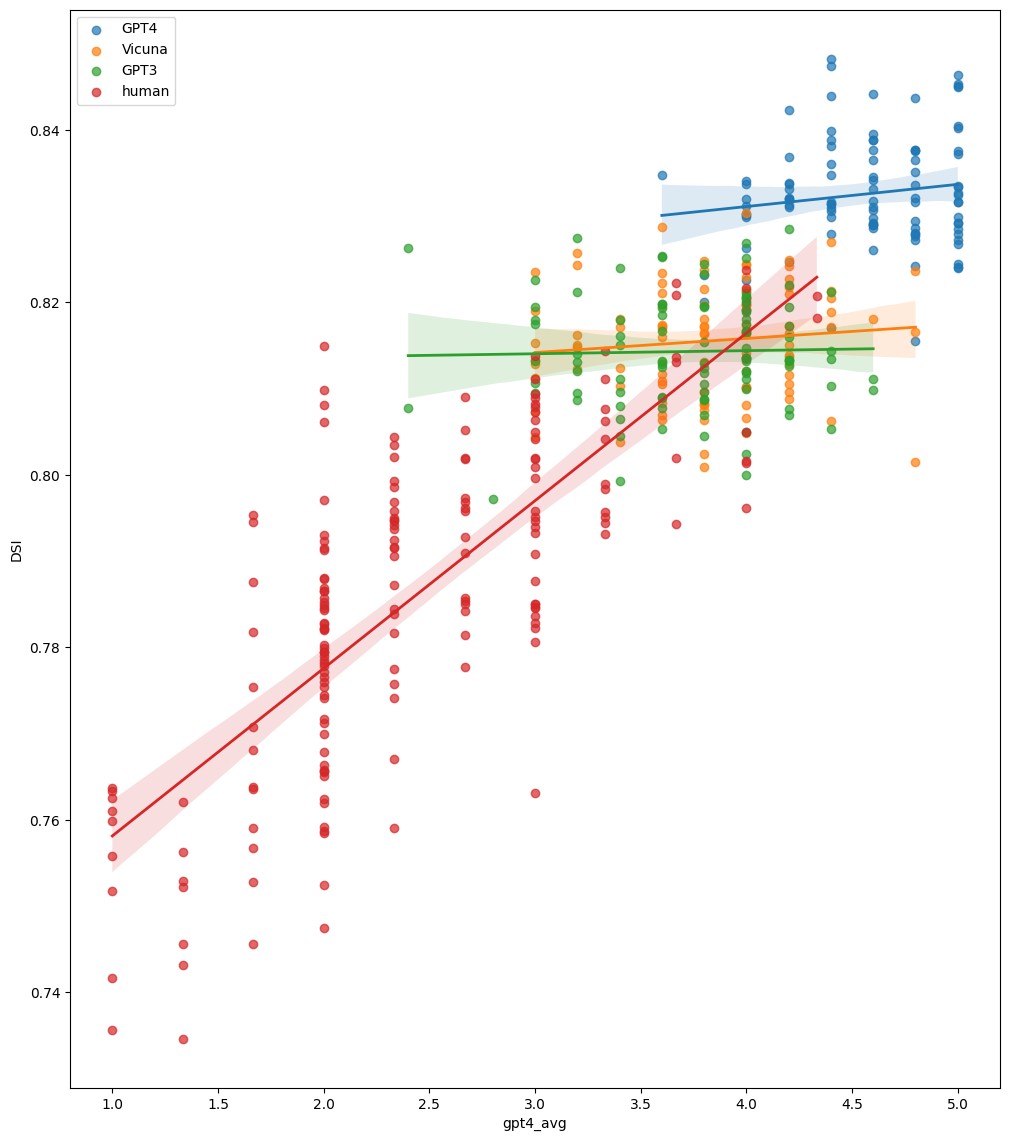

In [14]:
fig, ax= plt.subplots(1, 1, figsize=(12, 14))
condition = 'flash-fiction'
df = results_df.loc[(results_df['condition']==condition) &
                    (results_df['temp']=='Mid')].dropna(axis=1)

for model in df['model'].unique():
    sns.regplot(x='gpt4_avg', y='DSI', data=df.loc[df['model']==model], ax=ax, label=model, scatter_kws={'alpha':0.7}, line_kws={'lw':2})
    # add r value and p-value in upper right corner
    df.loc[df['model']==model]['gpt4_avg']
    r, p = stats.pearsonr(df.loc[df['model']==model]['gpt4_avg'], df.loc[df['model']==model]['DSI'])
    print(f"{model} | {condition} | Mid - r={r:.2f}, p={p:.2f}")
plt.legend()
plt.show()
    


# Distribution of ratings ; ranking models

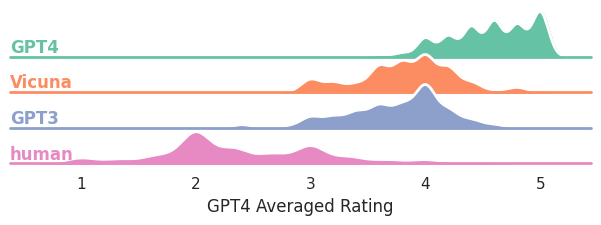

In [69]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
condition = 'flash-fiction'
df = results_df.loc[(results_df['condition']==condition) &
                    (results_df['temp']=='Mid')]

# Initialize the FacetGrid object
g = sns.FacetGrid(df, row="model", hue="model", aspect=15, height=.5, palette='Set2')

# Draw the densities in a few steps
g.map(sns.kdeplot, "gpt4_avg", clip_on=False, fill=True, alpha=1, lw=1.5, bw_adjust=.5,)
g.map(sns.kdeplot, "gpt4_avg", clip_on=False, color="w", lw=2, bw_adjust=.5,)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "gpt4_avg")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set_ylabels("")
g.set_xlabels("GPT4 Averaged Rating")
g.set(yticks=[])
g.despine(bottom=True, left=True)

--- Statistical Report ---
GPT4 (M=4.57, SD=0.36) vs Vicuna (M=3.83, SD=0.42): t(198) = 13.38, p < .001, d = 1.89
GPT4 (M=4.57, SD=0.36) vs GPT3 (M=3.74, SD=0.45): t(198) = 14.49, p < .001, d = 2.05
GPT4 (M=4.57, SD=0.36) vs human (M=2.40, SD=0.73): t(277) = 27.76, p < .001, d = 3.47
Vicuna (M=3.83, SD=0.42) vs human (M=2.40, SD=0.73): t(277) = 17.83, p < .001, d = 2.23
GPT3 (M=3.74, SD=0.45) vs human (M=2.40, SD=0.73): t(277) = 16.61, p < .001, d = 2.07
--------------------------



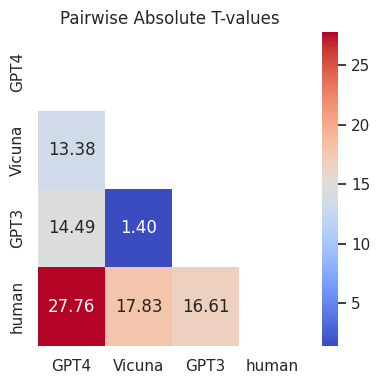

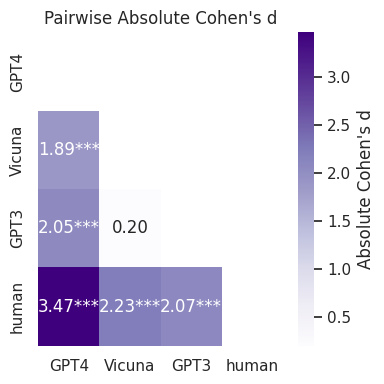

In [74]:
import numpy as np
condition = 'flash-fiction'
df = results_df.loc[(results_df['condition']==condition) &
                    (results_df['temp']=='Mid')]

models = df['model'].unique()
num_models = len(models)

# Initialize matrices to store p-values, Cohen's d, and annotations
t_values = np.zeros((num_models, num_models))
p_values = np.full((num_models, num_models), np.nan) # Use NaN default
cohens_d = np.full((num_models, num_models), np.nan) # Use NaN default
# Create matrix for annotations (strings)
heatmap_annotations = np.full((num_models, num_models), '', dtype=object)

print("--- Statistical Report ---")

# Perform pairwise t-tests and Cohen's d calculations
for i in range(num_models):
    for j in range(i, num_models): # Iterate only through unique pairs (j starts from i)
        if i == j: # Skip self-comparison for report and annotations
            heatmap_annotations[i, j] = '-' # Mark diagonal clearly
            continue

        model1_data = df[df['model'] == models[i]]['gpt4_avg']
        model2_data = df[df['model'] == models[j]]['gpt4_avg']

        n1, n2 = len(model1_data), len(model2_data)

        # Ensure sufficient data for t-test
        if n1 > 1 and n2 > 1:
            # --- Calculations ---
            t_stat, p = stats.ttest_ind(model1_data, model2_data, nan_policy='omit') # omit NaNs if any

            # Calculate Cohen's d
            mean1, mean2 = np.mean(model1_data), np.mean(model2_data)
            sd1, sd2 = np.std(model1_data, ddof=1), np.std(model2_data, ddof=1)
            # Calculate pooled standard deviation
            pooled_std_numerator = ((n1 - 1) * sd1**2 + (n2 - 1) * sd2**2)
            pooled_std_denominator = (n1 + n2 - 2)

            # Check for zero denominator or zero std devs which can cause issues
            if pooled_std_denominator > 0:
                 pooled_std = np.sqrt(pooled_std_numerator / pooled_std_denominator)
                 if pooled_std > 1e-9: # Avoid division by near-zero
                     d = (mean1 - mean2) / pooled_std
                 else:
                     d = np.nan # Assign NaN if pooled_std is effectively zero
            else:
                 d = np.nan # Assign NaN if cannot calculate pooled_std

            # Store results (store for both (i,j) and (j,i) for full matrix)
            t_values[i, j], t_values[j, i] = t_stat, -t_stat # t(A,B) = -t(B,A)
            p_values[i, j], p_values[j, i] = p, p          # p(A,B) = p(B,A)
            cohens_d[i, j], cohens_d[j, i] = d, -d         # d(A,B) = -d(B,A)

            # --- Significance Stars ---
            if pd.isna(p):
                stars = ''
            elif p < 0.001:
                stars = '***'
                p_str = "p < .001"
            elif p < 0.01:
                stars = '**'
                p_str = f"p = {p:.3f}"
            elif p < 0.05:
                stars = '*'
                p_str = f"p = {p:.3f}"
            else:
                stars = ''
                p_str = f"p = {p:.3f}"

            # --- Create Annotation String ---
            if not pd.isna(d):
                 annot_text = f"{abs(d):.2f}{stars}" # Show absolute d value on heatmap
            else:
                 annot_text = "N/A"
            heatmap_annotations[i, j] = annot_text
            heatmap_annotations[j, i] = annot_text # Use same text for symmetry visually


            # --- Print Report if Significant ---
            if p < 0.05 and not pd.isna(d): # Check significance and valid d
                 dof = n1 + n2 - 2
                 # Report means/SDs for both groups for clarity
                 report = (f"{models[i]} (M={mean1:.2f}, SD={sd1:.2f}) vs "
                           f"{models[j]} (M={mean2:.2f}, SD={sd2:.2f}): "
                           f"t({dof}) = {t_stat:.2f}, {p_str}, d = {d:.2f}")
                 print(report)

        else:
             # Handle cases with insufficient data - Ensure annotations reflect this
             heatmap_annotations[i, j] = "N/A"
             heatmap_annotations[j, i] = "N/A"
             if i != j: # Avoid printing 'no data' for diagonal
                 print(f"Skipping {models[i]} vs {models[j]} due to insufficient data (n1={n1}, n2={n2})")

print("--------------------------\n")


# Create DataFrames for the heatmaps
# Use absolute values for color intensity, but original signs might be useful elsewhere
t_val_df = pd.DataFrame(t_values, index=models, columns=models)
cohens_d_df = pd.DataFrame(cohens_d, index=models, columns=models)
annot_df = pd.DataFrame(heatmap_annotations, index=models, columns=models)

# --- Plotting ---

# Create a mask for the upper triangle (including diagonal)
mask = np.triu(np.ones_like(cohens_d_df, dtype=bool))

# Plot the heatmap of T-values (Optional - keeping original style)
plt.figure(figsize=(4, 4)) # Adjusted size slightly
sns.heatmap(abs(t_val_df), annot=True, fmt=".2f", cmap="coolwarm", mask=mask) # Mask added here too
plt.title(f'Pairwise Absolute T-values ')
plt.tight_layout() # Adjust layout
plt.show()

# Plot the heatmap of Cohen's d with significance annotations
plt.figure(figsize=(4, 4)) # Adjusted size slightly
# Use abs(cohens_d_df) for color intensity, annot_df for the text labels
sns.heatmap(abs(cohens_d_df), annot=annot_df, fmt='', cmap="Purples",
            mask=mask, cbar_kws={'label': "Absolute Cohen's d"}) # Added cbar label
plt.title(f"Pairwise Absolute Cohen's d")
plt.tight_layout() # Adjust layout
plt.show()

## For each rating instance

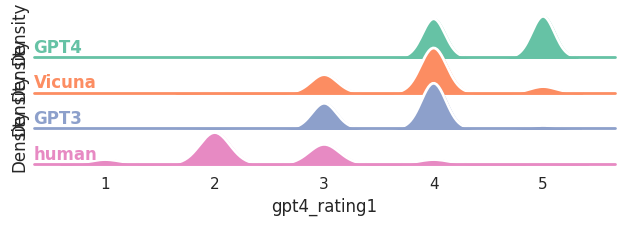

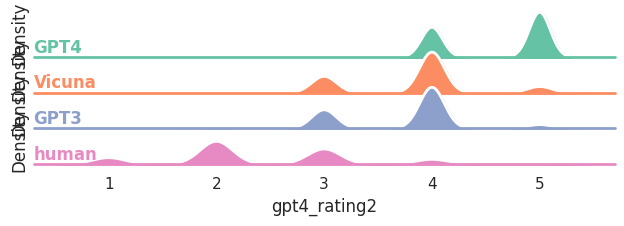

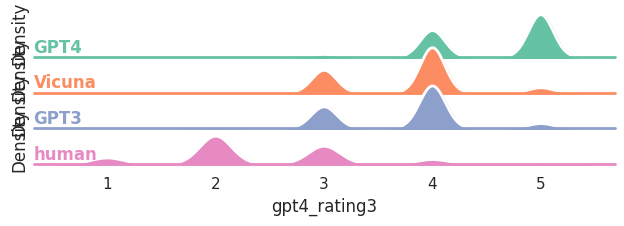

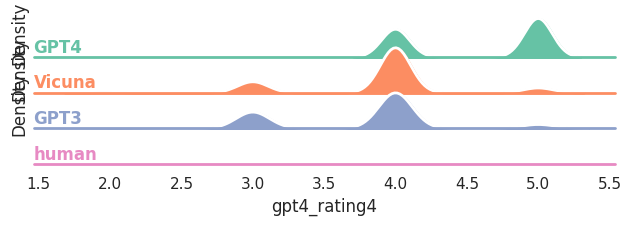

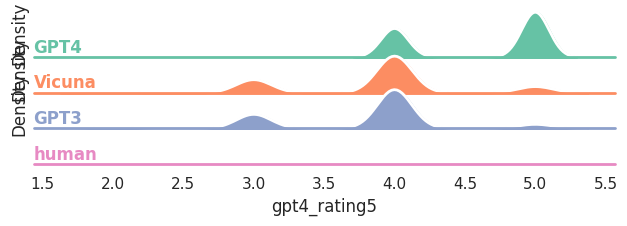

In [16]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
condition = 'flash-fiction'
df = results_df.loc[(results_df['condition'] == condition) &
                    (results_df['temp'] == 'Mid') ]
                    #(results_df['model'] != 'human')
                    

# Create a "combined" column to merge model and rater information
for rating_column in ['gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3', 'gpt4_rating4', 'gpt4_rating5']:
    df[rating_column + '_combined'] = df['model'] + ' - ' + rating_column

# Now, we'll initialize the FacetGrid multiple times, once for each rater, and plot them
for rating_column in ['gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3', 'gpt4_rating4', 'gpt4_rating5']:
    
    g = sns.FacetGrid(df, row=rating_column + '_combined', hue="model", aspect=15, height=.5, palette='Set2')

    g.map(sns.kdeplot, rating_column, clip_on=False, fill=True, alpha=1, lw=1.5, bw_adjust=.5)
    g.map(sns.kdeplot, rating_column, clip_on=False, color="w", lw=2, bw_adjust=.5)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label.split(' - ')[0], fontweight="bold", color=color,  # Only the model name is displayed
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, rating_column)

    # Set the subplots to overlap and remove axes details
    g.fig.subplots_adjust(hspace=-.25)
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)


# Multiple regression models
## Human stories

In [18]:
import pingouin as pg
condition = 'flash-fiction'

df = results_df.loc[(results_df['condition']==condition) &  (results_df['temp']=='Mid') & (results_df['model']=='human')]
stats_df = pg.linear_regression(X=df[['num_words', 'lziv', 'StoryRaterMean', 'gpt4_avg']], y=df['DSI'], relimp=True)
stats_df.round(4)


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%],relimp,relimp_perc
0,Intercept,0.6804,0.0181,37.6834,0.0000,0.694,0.687,0.6448,0.7161,NaN,NaN
1,num_words,0.0001,0.0000,3.8311,0.0002,0.694,0.687,0.0001,0.0002,0.1494,21.5193
2,lziv,0.0779,0.0266,2.9312,0.0038,0.694,0.687,0.0254,0.1303,0.0199,2.8662
3,StoryRaterMean,0.0072,0.0013,5.5912,0.0000,0.694,0.687,0.0046,0.0097,0.2660,38.3327
4,gpt4_avg,0.0093,0.0016,5.7475,0.0000,0.694,0.687,0.0061,0.0125,0.2588,37.2818


## LLM stories

In [7]:
import pingouin as pg
condition = 'flash-fiction'

df = results_df.loc[(results_df['condition']==condition) &  (results_df['temp']=='Mid') & (results_df['model']!='human')]
stats_df = pg.linear_regression(X=df[['num_words', 'lziv', 'gpt4_avg']], y=df['DSI'], relimp=True)
stats_df.round(4)


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%],relimp,relimp_perc
0,Intercept,0.6742,0.0155,43.6355,0.0000,0.5012,0.4961,0.6438,0.7046,NaN,NaN
1,num_words,0.0002,0.0000,9.9158,0.0000,0.5012,0.4961,0.0001,0.0002,0.2729,54.4496
2,lziv,0.0885,0.0251,3.5196,0.0005,0.5012,0.4961,0.0390,0.1380,0.0275,5.4779
3,gpt4_avg,0.0061,0.0009,6.7295,0.0000,0.5012,0.4961,0.0043,0.0079,0.2008,40.0725


## Let's look into number of words

Text(0.5, 0.95, 'flash-fiction | Mid - r=0.61, p=0.00')

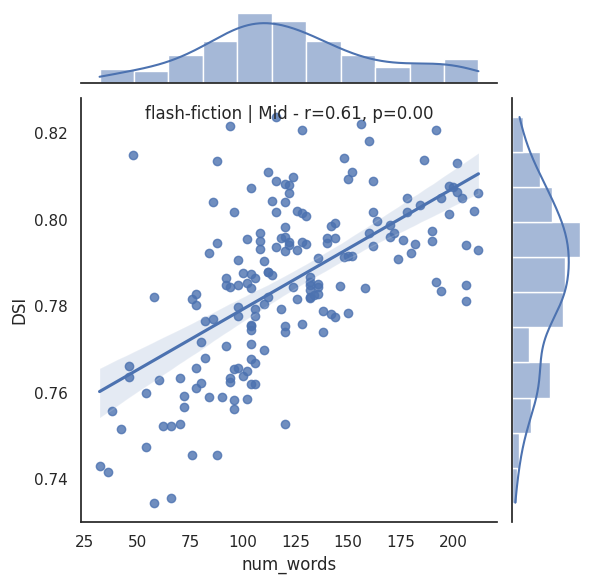

In [10]:
condition = 'flash-fiction'

df = results_df.loc[(results_df['condition']==condition) &  (results_df['temp']=='Mid') & (results_df['model']=='human')]

g = sns.jointplot(x='num_words', y='DSI', data=df ,kind='reg')
# add r value and p-value in upper right corner
r, p = stats.pearsonr(df['num_words'], df['DSI'])
g.ax_joint.annotate(f"{condition} | Mid - r={r:.2f}, p={p:.2f}", xy=(0.5, 0.95), xycoords='axes fraction', ha='center')


In [11]:
import statsmodels.api as sm
df = results_df.loc[(results_df['condition']==condition) &  (results_df['temp']=='Mid') & (results_df['model']!='human')].copy()
# create the X and y arrays for the regression model
X = df[['num_words', 'lziv', 'DSI']]
y = df['gpt4_avg']

# add a constant to the X array
X = sm.add_constant(X)

# fit the regression model
model = sm.OLS(y, X).fit()

# perform the F-test
t_test = model.t_test('DSI = lziv = num_words = 0')
print(t_test)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            18.4499      3.892      4.740      0.000      10.790      26.110
c1             3.1469      1.511      2.083      0.038       0.173       6.120
c2             0.0042      0.001      3.793      0.000       0.002       0.006


# Inter-rater reliability
## Cohen's kappa on human stories

In [13]:
from sklearn.metrics import cohen_kappa_score
filtered_df = results_df[(results_df['condition'] == 'flash-fiction') & (results_df['temp'] == 'Mid') & (results_df['model'] == 'human')]

# calculate Cohen's kappa for the human raters
human_ratings = ['StoryRater1', 'StoryRater2', 'StoryRater3', 'StoryRater4', 'StoryRater5']
human_kappas = []
for i in range(len(human_ratings)):
    for j in range(i+1, len(human_ratings)):
        kappa = cohen_kappa_score(filtered_df[human_ratings[i]], filtered_df[human_ratings[j]])
        human_kappas.append(kappa)

# calculate Cohen's kappa for the gpt4 ratings
gpt4_ratings = ['gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3']
gpt4_kappas = []
for i in range(len(gpt4_ratings)):
    for j in range(i+1, len(gpt4_ratings)):
        kappa = cohen_kappa_score(filtered_df[gpt4_ratings[i]], filtered_df[gpt4_ratings[j]])
        gpt4_kappas.append(kappa)

# print the average kappa for each group of raters
print(f"Average Cohen's kappa for human raters: {sum(human_kappas)/len(human_kappas):.2f}")
print(f"Average Cohen's kappa for gpt4 raters: {sum(gpt4_kappas)/len(gpt4_kappas):.2f}")

Average Cohen's kappa for human raters: 0.25
Average Cohen's kappa for gpt4 raters: 0.48


In [14]:
from sklearn.metrics import cohen_kappa_score
for model in results_df['model'].unique():
    if model == 'human':
        continue
    filtered_df = results_df[(results_df['condition'] == 'flash-fiction') & (results_df['temp'] == 'Mid') & (results_df['model'] == model)]

    # calculate Cohen's kappa for the gpt4 ratings
    gpt4_ratings = ['gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3', 'gpt4_rating4', 'gpt4_rating5']
    gpt4_kappas = []
    for i in range(len(gpt4_ratings)):
        for j in range(i+1, len(gpt4_ratings)):
            kappa = cohen_kappa_score(filtered_df[gpt4_ratings[i]], filtered_df[gpt4_ratings[j]])
            gpt4_kappas.append(kappa)

    # print the average kappa for raters
    print(f"Average Cohen's kappa for gpt4 raters on {model} stories: {sum(gpt4_kappas)/len(gpt4_kappas):.2f}")

Average Cohen's kappa for gpt4 raters on GPT3 stories: 0.30
Average Cohen's kappa for gpt4 raters on GPT4 stories: 0.31
Average Cohen's kappa for gpt4 raters on Vicuna stories: 0.27


In [15]:
import numpy as np

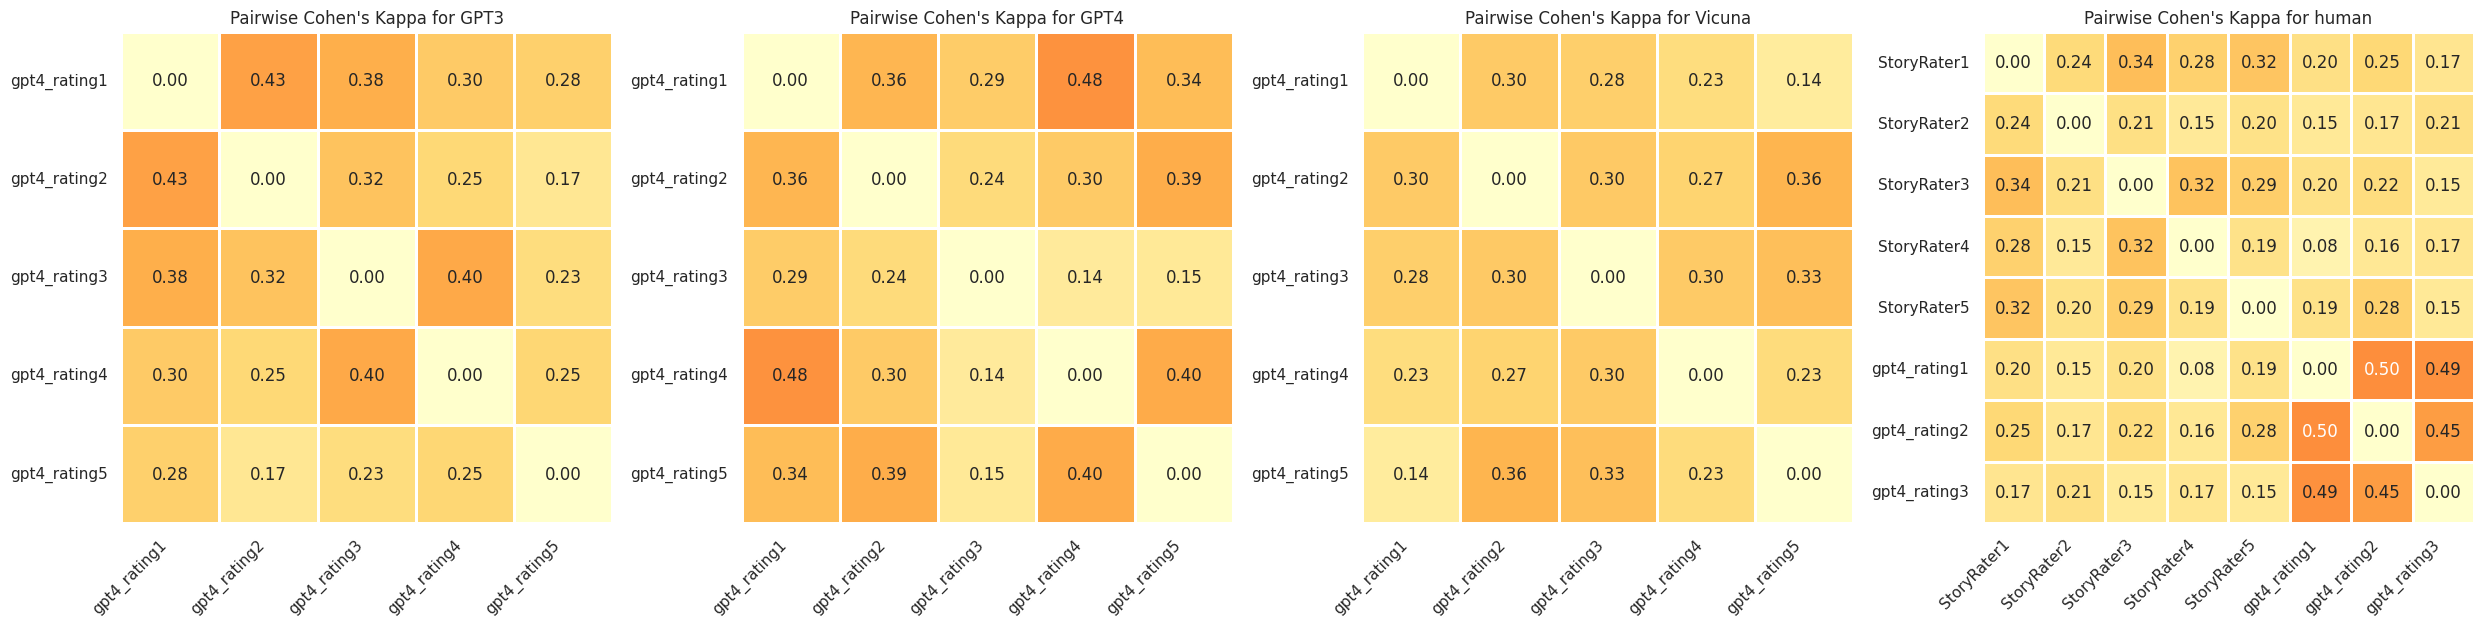

In [61]:
# Update rater mapping for 'human' to include both human and 3 GPT-4 raters
raters = {}
raters['human'] = ['StoryRater1', 'StoryRater2', 'StoryRater3', 'StoryRater4', 'StoryRater5', 'gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3']

# Models to consider
selected_models = ['GPT3', 'GPT4', 'Vicuna', 'human']
raters['GPT3'] = ['gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3', 'gpt4_rating4', 'gpt4_rating5']
raters['GPT4'] = ['gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3', 'gpt4_rating4', 'gpt4_rating5']
raters['Vicuna'] = ['gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3', 'gpt4_rating4', 'gpt4_rating5']
# Recompute the kappa matrices for the selected models
selected_model_kappa_results = {}
for model in selected_models:
    model_raters = raters[model]
    filtered_df = results_df[(results_df['condition'] == 'flash-fiction') & (results_df['temp'] == 'Mid') & (results_df['model'] == model)].dropna(axis=1)
    
    # Drop rows with any NaN in model raters
    filtered_df = filtered_df.dropna(subset=model_raters)
    
    # Create a matrix to store kappa scores
    kappa_matrix = np.zeros((len(model_raters), len(model_raters)))
    
    for i in range(len(model_raters)):
        for j in range(len(model_raters)):
            if i != j:
                kappa_matrix[i, j] = cohen_kappa_score(filtered_df[model_raters[i]], filtered_df[model_raters[j]])
                
    selected_model_kappa_results[model] = kappa_matrix

# Plot the matrix plots for the selected models using a warm palette
plt.figure(figsize=(25, 15))

for idx, (model, kappa_matrix) in enumerate(selected_model_kappa_results.items()):
    ax = plt.subplot(1, len(selected_model_kappa_results), idx+1)
    
    # Plot the matrix with annotations using the "YlOrRd" (yellow-orange-red) palette
    sns.heatmap(kappa_matrix, annot=True, cmap="YlOrRd", cbar=False, ax=ax, 
                vmin=0, vmax=1, linewidths=1, square=True, fmt=".2f")
    
    ax.set_xticks(np.arange(len(raters[model]))+0.5)
    ax.set_xticklabels(raters[model], rotation=45, ha='right')
    ax.set_yticks(np.arange(len(raters[model]))+0.5)
    ax.set_yticklabels(raters[model], rotation=0)
    ax.set_title(f"Pairwise Cohen's Kappa for {model}")

plt.tight_layout()
plt.show()

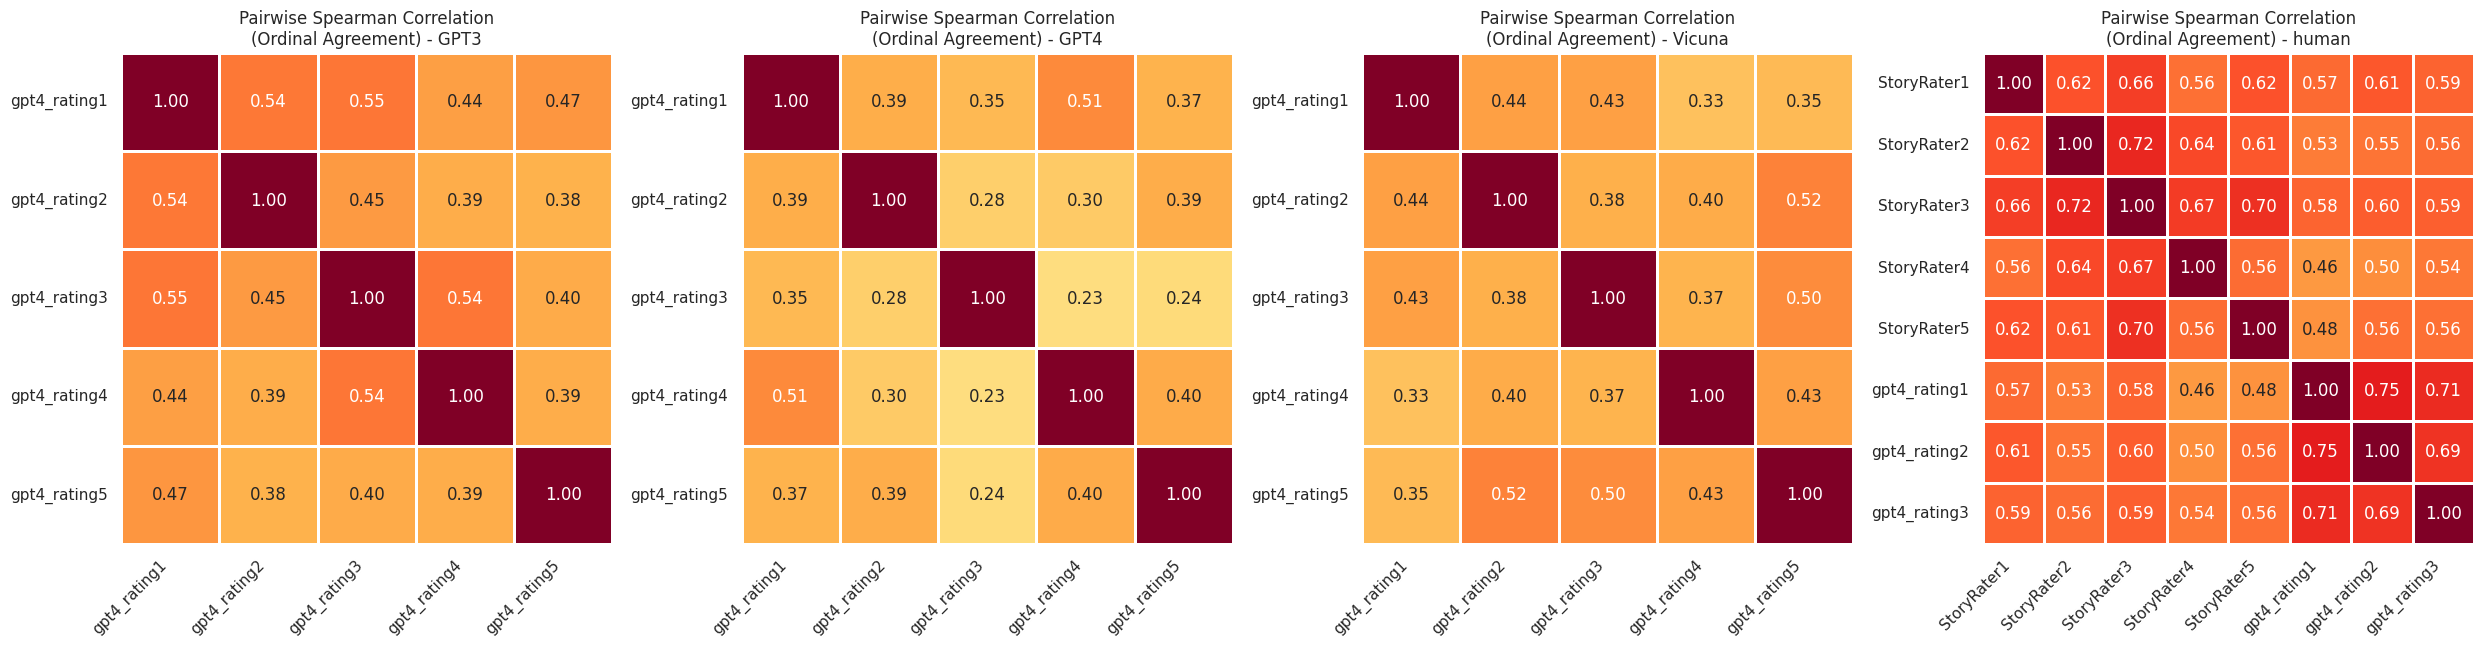

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Define raters for each model
raters = {
    'human': ['StoryRater1', 'StoryRater2', 'StoryRater3', 'StoryRater4', 'StoryRater5', 'gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3'],
    'GPT3': ['gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3', 'gpt4_rating4', 'gpt4_rating5'],
    'GPT4': ['gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3', 'gpt4_rating4', 'gpt4_rating5'],
    'Vicuna': ['gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3', 'gpt4_rating4', 'gpt4_rating5']
}

selected_models = ['GPT3', 'GPT4', 'Vicuna', 'human']
ordinal_model_spearman_results = {}

for model in selected_models:
    model_raters = raters[model]
    filtered_df = results_df[(results_df['condition'] == 'flash-fiction') & 
                             (results_df['temp'] == 'Mid') & 
                             (results_df['model'] == model)].dropna(subset=model_raters)

    # Create a matrix to store Spearman correlations
    spearman_matrix = np.zeros((len(model_raters), len(model_raters)))
    
    for i in range(len(model_raters)):
        for j in range(len(model_raters)):
            if i != j:
                corr, _ = spearmanr(filtered_df[model_raters[i]], filtered_df[model_raters[j]])
                spearman_matrix[i, j] = corr
            else:
                spearman_matrix[i, j] = 1.0  # Perfect correlation with self
    
    ordinal_model_spearman_results[model] = spearman_matrix

# Plot the Spearman correlation matrices
plt.figure(figsize=(25, 15))

for idx, (model, spearman_matrix) in enumerate(ordinal_model_spearman_results.items()):
    ax = plt.subplot(1, len(ordinal_model_spearman_results), idx+1)
    sns.heatmap(spearman_matrix, annot=True, cmap="YlOrRd", cbar=False, ax=ax,
                vmin=0, vmax=1, linewidths=1, square=True, fmt=".2f")
    
    ax.set_xticks(np.arange(len(raters[model])) + 0.5)
    ax.set_xticklabels(raters[model], rotation=45, ha='right')
    ax.set_yticks(np.arange(len(raters[model])) + 0.5)
    ax.set_yticklabels(raters[model], rotation=0)
    ax.set_title(f"Pairwise Spearman Correlation\n(Ordinal Agreement) - {model}")

plt.tight_layout()
plt.show()


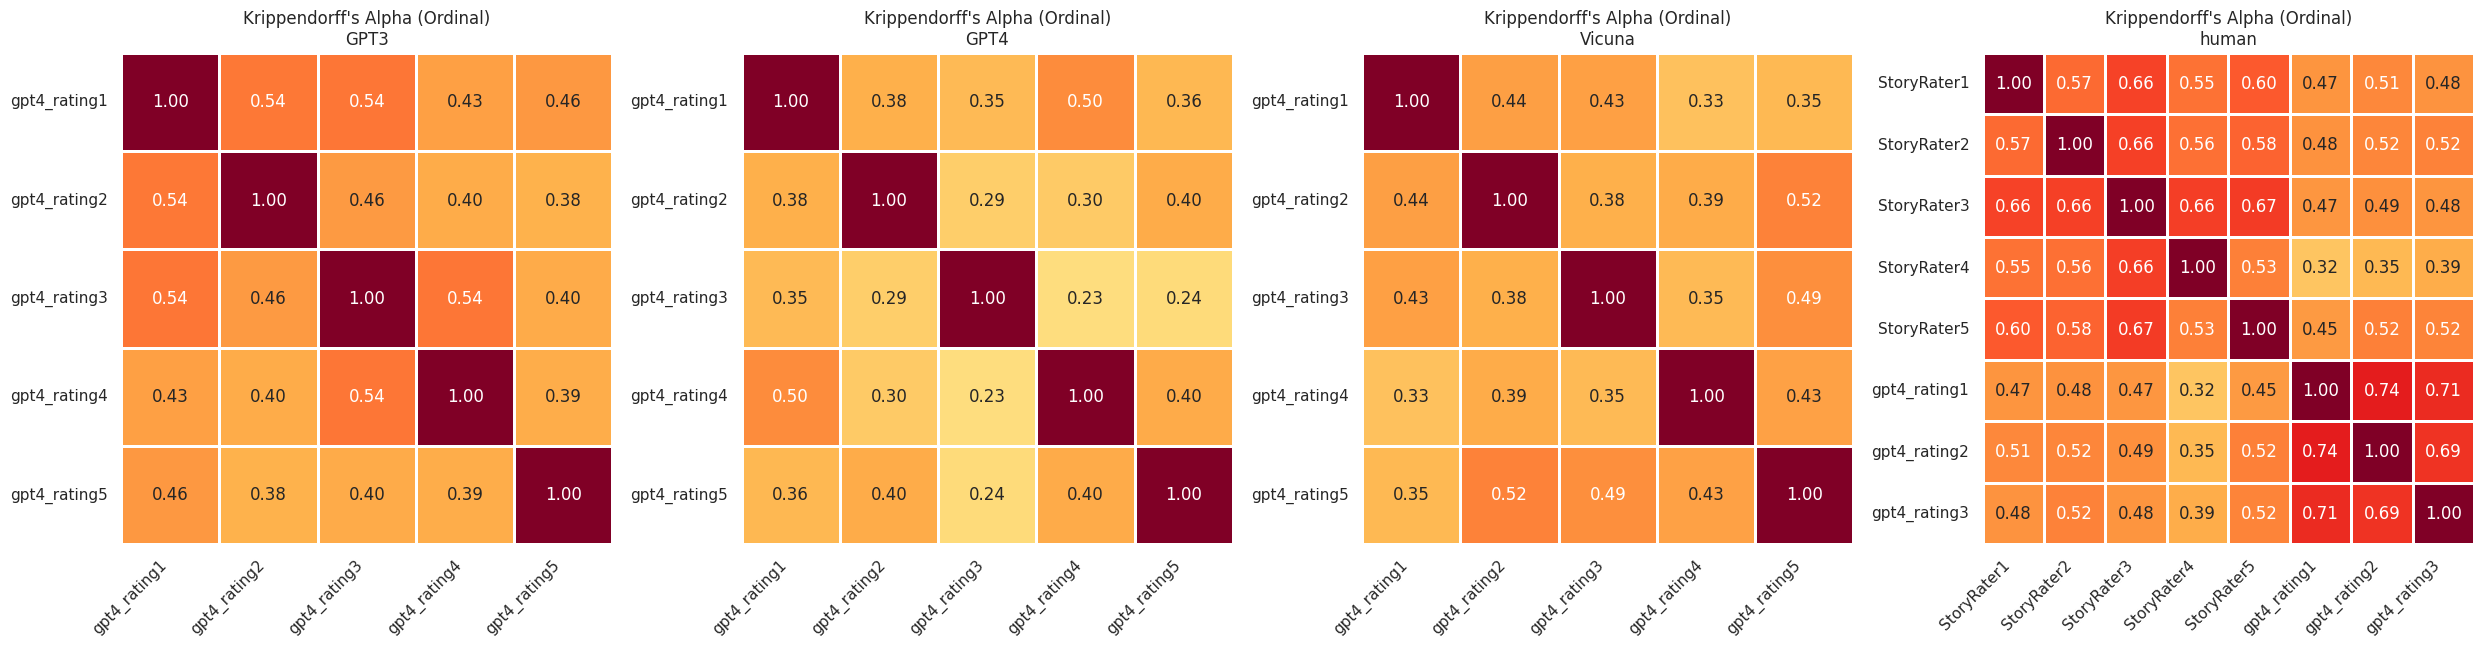

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import krippendorff  # Make sure this is installed: pip install krippendorff

# Define raters for each model
raters = {
    'human': ['StoryRater1', 'StoryRater2', 'StoryRater3', 'StoryRater4', 'StoryRater5', 'gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3'],
    'GPT3': ['gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3', 'gpt4_rating4', 'gpt4_rating5'],
    'GPT4': ['gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3', 'gpt4_rating4', 'gpt4_rating5'],
    'Vicuna': ['gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3', 'gpt4_rating4', 'gpt4_rating5']
}

selected_models = ['GPT3', 'GPT4', 'Vicuna', 'human']
kripp_matrix_results = {}

for model in selected_models:
    model_raters = raters[model]
    filtered_df = results_df[(results_df['condition'] == 'flash-fiction') &
                             (results_df['temp'] == 'Mid') &
                             (results_df['model'] == model)].dropna(subset=model_raters)

    # Transpose the data to [raters x items]
    data = filtered_df[model_raters].T.values
    n = len(model_raters)
    
    # Initialize Krippendorff matrix
    alpha_matrix = np.ones((n, n))

    for i in range(n):
        for j in range(n):
            if i != j:
                pair_data = filtered_df[[model_raters[i], model_raters[j]]].dropna().T.values
                if pair_data.shape[1] > 1:
                    alpha = krippendorff.alpha(reliability_data=pair_data, level_of_measurement='ordinal')
                else:
                    alpha = np.nan  # Not enough data
                alpha_matrix[i, j] = alpha

    kripp_matrix_results[model] = alpha_matrix

# Plot Krippendorff’s alpha heatmaps
plt.figure(figsize=(25, 15))

for idx, (model, alpha_matrix) in enumerate(kripp_matrix_results.items()):
    ax = plt.subplot(1, len(kripp_matrix_results), idx+1)
    sns.heatmap(alpha_matrix, annot=True, cmap="YlOrRd", cbar=False, ax=ax,
                vmin=0, vmax=1, linewidths=1, square=True, fmt=".2f", mask=np.isnan(alpha_matrix))
    
    ax.set_xticks(np.arange(len(raters[model])) + 0.5)
    ax.set_xticklabels(raters[model], rotation=45, ha='right')
    ax.set_yticks(np.arange(len(raters[model])) + 0.5)
    ax.set_yticklabels(raters[model], rotation=0)
    ax.set_title(f"Krippendorff's Alpha (Ordinal)\n{model}")

plt.tight_layout()
plt.show()


In [ ]:
import pingouin as pg
from scipy.stats import shapiro

In [40]:
gpt4_ratings = results_df.loc[results_df['model']=='human'][["gpt4_rating1", "gpt4_rating2", "gpt4_rating3"]]
human_ratings = results_df[["StoryRater1", "StoryRater2", "StoryRater3", "StoryRater4", "StoryRater5"]]

In [41]:
gpt4_normality = gpt4_ratings.apply(lambda x: shapiro(x.dropna())[1])  # p-values
human_normality = human_ratings.apply(lambda x: shapiro(x.dropna())[1])  # p-values

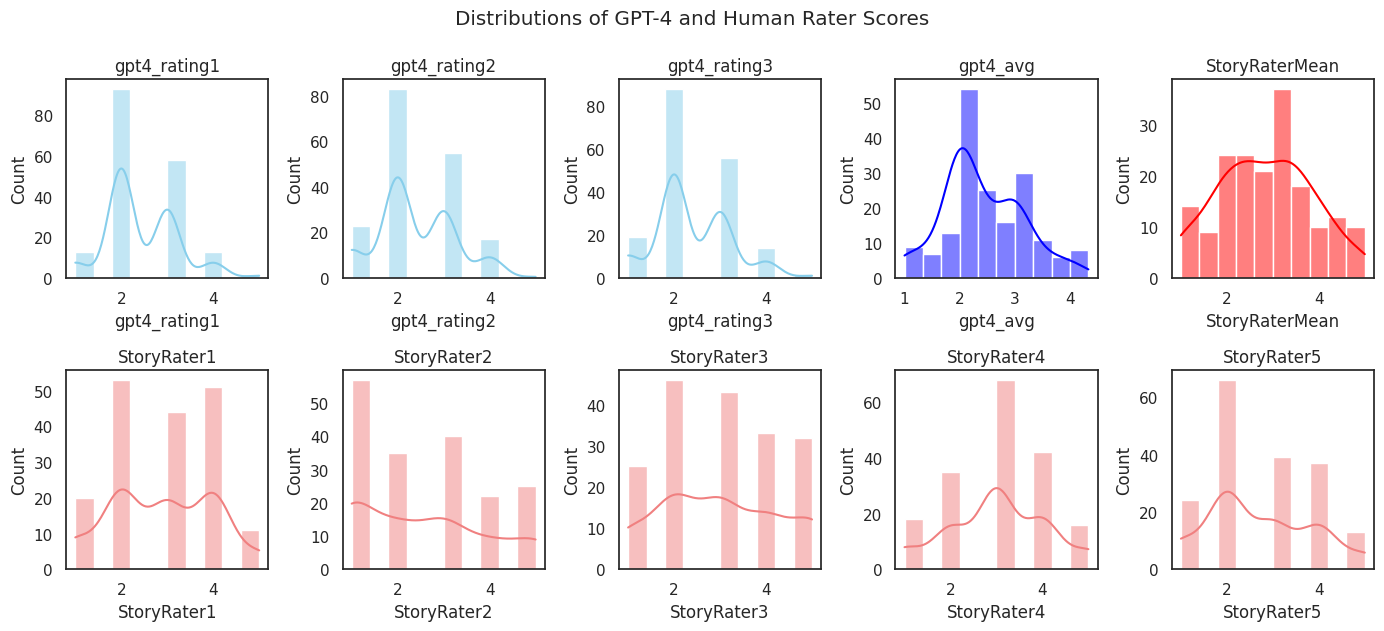

In [47]:
# Plot distributions
plt.figure(figsize=(14, 6))

for i, col in enumerate(gpt4_ratings.columns):
    plt.subplot(2, 5, i + 1)
    sns.histplot(gpt4_ratings[col].dropna(), kde=True, bins=10, color='skyblue')
    plt.title(f"{col}")

for i, col in enumerate(["gpt4_avg", "StoryRaterMean"]):
    color = 'blue' if col == 'gpt4_avg' else 'red'
    plt.subplot(2, 5, i + 4)
    sns.histplot(results_df.loc[results_df['model']=='human'][col].dropna(), kde=True, bins=10, color=color)
    plt.title(f"{col}")

for i, col in enumerate(human_ratings.columns):
    plt.subplot(2, 5, i + 6)
    sns.histplot(human_ratings[col].dropna(), kde=True, bins=10, color='lightcoral')
    plt.title(f"{col}")

plt.tight_layout()
plt.suptitle("Distributions of GPT-4 and Human Rater Scores", y=1.05)
plt.show()

In [27]:
# Compute ICC for GPT-4 raters
df_gpt = gpt4_ratings.reset_index().melt(id_vars='index', var_name='rater', value_name='score')
df_gpt = df_gpt.rename(columns={'index': 'target'})
icc_gpt4 = pg.intraclass_corr(data=df_gpt, targets='target', raters='rater', ratings='score', nan_policy='omit')

# Compute ICC for Human raters
df_human = human_ratings.reset_index().melt(id_vars='index', var_name='rater', value_name='score')
df_human = df_human.rename(columns={'index': 'target'})
icc_human = pg.intraclass_corr(data=df_human, targets='target', raters='rater', ratings='score')

# Prepare data for Krippendorff’s alpha (each column = rater, each row = item)
gpt4_matrix = gpt4_ratings.T.values
human_matrix = human_ratings.T.values

# Compute Krippendorff’s alpha
alpha_gpt4 = krippendorff.alpha(reliability_data=gpt4_matrix, level_of_measurement='ordinal')
alpha_human = krippendorff.alpha(reliability_data=human_matrix, level_of_measurement='ordinal')

icc_gpt4_summary = icc_gpt4[['Type', 'ICC', 'CI95%', 'F', 'pval']].drop_duplicates(subset='Type')
icc_human_summary = icc_human[['Type', 'ICC', 'CI95%', 'F', 'pval']].drop_duplicates(subset='Type')

icc_gpt4_summary, alpha_gpt4, icc_human_summary, alpha_human

(    Type       ICC         CI95%         F           pval
 0   ICC1  0.589635  [0.54, 0.64]  8.184274  1.462486e-155
 1   ICC2  0.589752  [0.54, 0.64]  8.212770  7.827900e-156
 2   ICC3  0.590592  [0.54, 0.64]  8.212770  7.827900e-156
 3  ICC1k  0.877814   [0.85, 0.9]  8.184274  1.462486e-155
 4  ICC2k  0.877866   [0.85, 0.9]  8.212770  7.827900e-156
 5  ICC3k  0.878238   [0.86, 0.9]  8.212770  7.827900e-156,
 0.7823082608086098,
     Type       ICC         CI95%         F           pval
 0   ICC1  0.621932  [0.56, 0.68]  9.225122  5.979478e-105
 1   ICC2  0.623626  [0.56, 0.69]  9.809224  1.234670e-110
 2   ICC3  0.637923   [0.58, 0.7]  9.809224  1.234670e-110
 3  ICC1k  0.891600  [0.86, 0.91]  9.225122  5.979478e-105
 4  ICC2k  0.892296  [0.86, 0.92]  9.809224  1.234670e-110
 5  ICC3k  0.898055  [0.87, 0.92]  9.809224  1.234670e-110,
 0.613856356097382)

In [29]:
import pandas as pd
from scipy.stats import wilcoxon, spearmanr

# Ensure both DataFrames have the same indices
common_index = gpt4_ratings.index.intersection(human_ratings.index)

# Compute average ratings
gpt4_avg = gpt4_ratings.loc[common_index].mean(axis=1)
human_avg = human_ratings.loc[common_index].mean(axis=1)

# Drop any rows with NaN values
paired_data = pd.DataFrame({
    'gpt4': gpt4_avg,
    'human': human_avg
}).dropna()

# Make sure there’s more than one unique value for Wilcoxon and Spearman
if (paired_data['gpt4'] != paired_data['human']).any():
    wilcoxon_result = wilcoxon(paired_data['gpt4'], paired_data['human'])
else:
    wilcoxon_result = None

if paired_data['gpt4'].nunique() > 1 and paired_data['human'].nunique() > 1:
    spearman_corr, spearman_p = spearmanr(paired_data['gpt4'], paired_data['human'])
else:
    spearman_corr, spearman_p = None, None

# Print results
print("Wilcoxon signed-rank test:")
if wilcoxon_result:
    print(f"Statistic = {wilcoxon_result.statistic}, p-value = {wilcoxon_result.pvalue}")
else:
    print("Not enough variation for Wilcoxon test.")

print("\nSpearman correlation:")
if spearman_corr is not None:
    print(f"Correlation = {spearman_corr}, p-value = {spearman_p}")
else:
    print("Not enough variation for Spearman correlation.")


Wilcoxon signed-rank test:
Statistic = 2298.5, p-value = 3.6372330549220066e-13

Spearman correlation:
Correlation = 0.7227873054437363, p-value = 3.2478921744373004e-30


Mean agreement values:
Human-Human: 0.6037 ± 0.0510
Human-GPT: 0.4654 ± 0.0612
GPT-GPT: 0.7135 ± 0.0220

Statistical test (Human-Human vs Human-GPT):
t-statistic: 5.8641
p-value: 0.000007
The difference is statistically significant (p < 0.05)


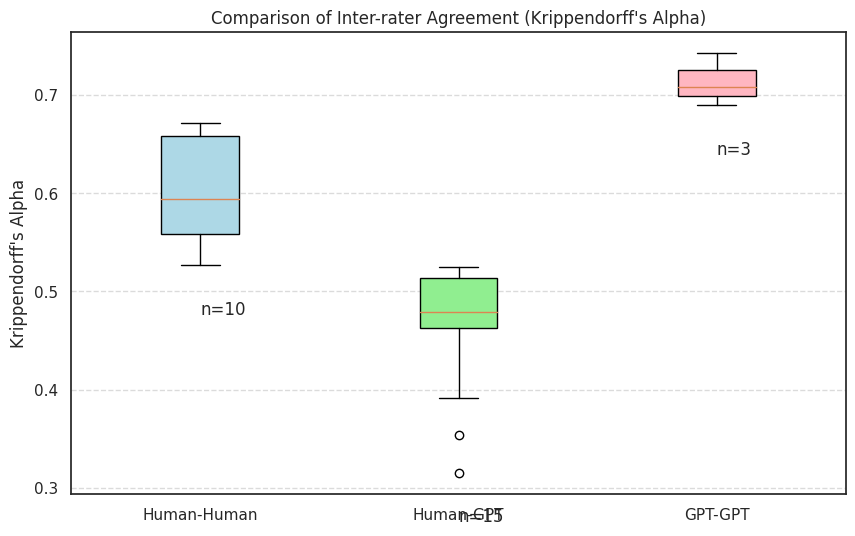

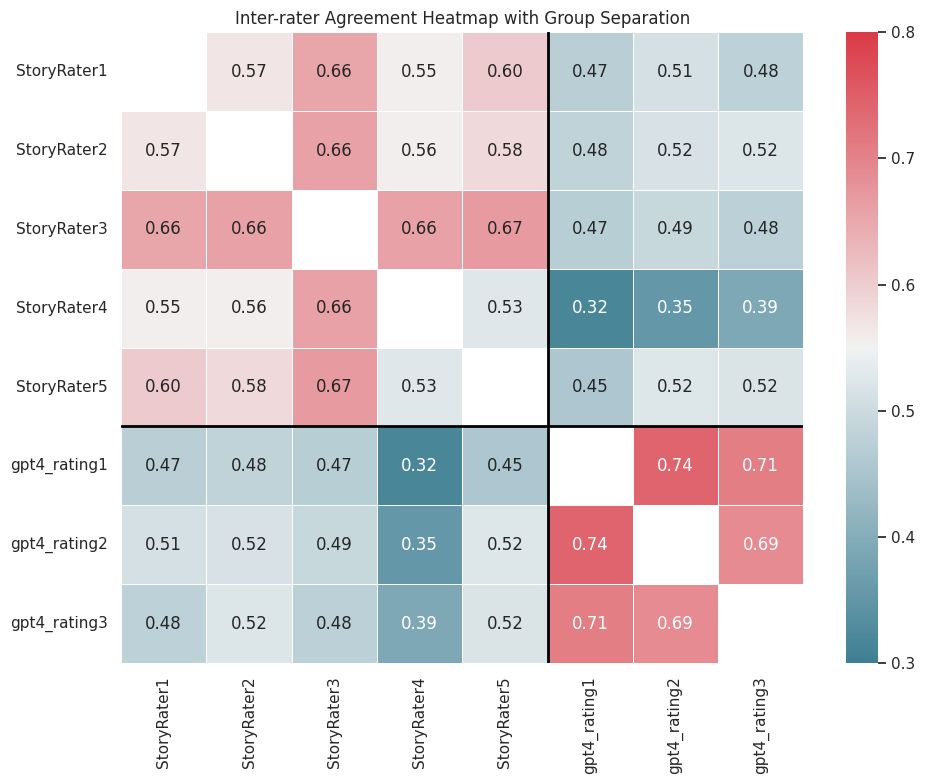


Group agreement analysis:
Mean Human-Human agreement: 0.6037
Mean Human-GPT agreement: 0.4654
Mean GPT-GPT agreement: 0.7135

Ratio of Human-GPT to Human-Human agreement: 0.7709
Difference between Human-Human and Human-GPT agreement: 0.1383


In [34]:
human_matrix = alpha_matrix
# Define the rater groups
human_raters = ['StoryRater1', 'StoryRater2', 'StoryRater3', 'StoryRater4', 'StoryRater5']
gpt_raters = ['gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3']
all_raters = human_raters + gpt_raters

# Get indices for each group
human_indices = [all_raters.index(rater) for rater in human_raters]
gpt_indices = [all_raters.index(rater) for rater in gpt_raters]

# Extract agreement values for human-human pairs
human_human_agreement = []
for i in human_indices:
    for j in human_indices:
        if i < j:  # Take only unique pairs and exclude self-agreement
            human_human_agreement.append(human_matrix[i, j])

# Extract agreement values for human-GPT pairs
human_gpt_agreement = []
for i in human_indices:
    for j in gpt_indices:
        human_gpt_agreement.append(human_matrix[i, j])

# Extract agreement values for GPT-GPT pairs
gpt_gpt_agreement = []
for i in gpt_indices:
    for j in gpt_indices:
        if i < j:  # Take only unique pairs and exclude self-agreement
            gpt_gpt_agreement.append(human_matrix[i, j])

# Calculate statistics for each group
h_h_mean = np.mean(human_human_agreement)
h_h_std = np.std(human_human_agreement)
h_g_mean = np.mean(human_gpt_agreement)
h_g_std = np.std(human_gpt_agreement)
g_g_mean = np.mean(gpt_gpt_agreement)
g_g_std = np.std(gpt_gpt_agreement)

# Perform statistical tests to see if the differences are significant
# Independent t-test for human-human vs human-GPT
t_stat, p_value = stats.ttest_ind(human_human_agreement, human_gpt_agreement, equal_var=False)

# Print results
print("Mean agreement values:")
print(f"Human-Human: {h_h_mean:.4f} ± {h_h_std:.4f}")
print(f"Human-GPT: {h_g_mean:.4f} ± {h_g_std:.4f}")
print(f"GPT-GPT: {g_g_mean:.4f} ± {g_g_std:.4f}")
print(f"\nStatistical test (Human-Human vs Human-GPT):")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.6f}")
if p_value < 0.05:
    print("The difference is statistically significant (p < 0.05)")
else:
    print("The difference is not statistically significant (p >= 0.05)")

# Create a boxplot to visualize the differences
plt.figure(figsize=(10, 6))
data_to_plot = [human_human_agreement, human_gpt_agreement, gpt_gpt_agreement]
labels = ['Human-Human', 'Human-GPT', 'GPT-GPT']
box = plt.boxplot(data_to_plot, labels=labels, patch_artist=True)

# Set colors
colors = ['lightblue', 'lightgreen', 'lightpink']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title("Comparison of Inter-rater Agreement (Krippendorff's Alpha)")
plt.ylabel("Krippendorff's Alpha")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Calculate and display the number of pairs in each category
num_hh_pairs = len(human_human_agreement)
num_hg_pairs = len(human_gpt_agreement)
num_gg_pairs = len(gpt_gpt_agreement)

# Add this information to the plot
plt.annotate(f"n={num_hh_pairs}", xy=(1, min(human_human_agreement)), 
             xytext=(1, min(human_human_agreement)-0.05))
plt.annotate(f"n={num_hg_pairs}", xy=(2, min(human_gpt_agreement)), 
             xytext=(2, min(human_gpt_agreement)-0.05))
plt.annotate(f"n={num_gg_pairs}", xy=(3, min(gpt_gpt_agreement)), 
             xytext=(3, min(gpt_gpt_agreement)-0.05))

plt.savefig('agreement_comparison.png')
plt.show()

# Additionally, let's create a heatmap that highlights the different rater groups
plt.figure(figsize=(10, 8))
mask = np.zeros_like(human_matrix, dtype=bool)
np.fill_diagonal(mask, True)  # Mask the diagonal

# Create a custom colormap to better visualize the differences
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot the heatmap
ax = sns.heatmap(human_matrix, annot=True, cmap=cmap, mask=mask,
            xticklabels=all_raters, yticklabels=all_raters,
            vmin=0.3, vmax=0.8, fmt='.2f', linewidths=0.5)

# Draw lines to separate the rater groups
plt.axhline(y=len(human_raters), color='black', linewidth=2)
plt.axvline(x=len(human_raters), color='black', linewidth=2)

# Add a title and labels
plt.title("Inter-rater Agreement Heatmap with Group Separation")
plt.tight_layout()

plt.savefig('grouped_heatmap.png')
plt.show()

# Let's also calculate the average agreement within each group and between groups
human_human_block = human_matrix[:len(human_raters), :len(human_raters)]
gpt_gpt_block = human_matrix[len(human_raters):, len(human_raters):]
human_gpt_block = human_matrix[:len(human_raters), len(human_raters):]

# Calculate the mean agreement for each block (excluding the diagonal for intra-group comparisons)
mask_diag = ~np.eye(human_human_block.shape[0], dtype=bool)
human_human_mean = human_human_block[mask_diag].mean()

mask_diag_gpt = ~np.eye(gpt_gpt_block.shape[0], dtype=bool)
gpt_gpt_mean = gpt_gpt_block[mask_diag_gpt].mean()

human_gpt_mean = human_gpt_block.mean()

print("\nGroup agreement analysis:")
print(f"Mean Human-Human agreement: {human_human_mean:.4f}")
print(f"Mean Human-GPT agreement: {human_gpt_mean:.4f}")
print(f"Mean GPT-GPT agreement: {gpt_gpt_mean:.4f}")

# Calculate the ratio of agreements
print(f"\nRatio of Human-GPT to Human-Human agreement: {human_gpt_mean/human_human_mean:.4f}")
print(f"Difference between Human-Human and Human-GPT agreement: {human_human_mean - human_gpt_mean:.4f}")

In [48]:
pooled_std = np.sqrt((h_h_std**2 + h_g_std**2) / 2)
cohens_d = (human_human_mean - human_gpt_mean) / pooled_std

In [49]:
cohens_d

2.456006294502864